# Project 3 - The U.S.S. Enterprise + 2D Gravitational Fields
# Aydin O'Leary and Jules Brettle

## Question
The U.S.S. Enterprise needs to go to Deep Space 9 for repairs, but they only have 1 impulse burst remaining and are on the wrong side of the planet Bajor. In which direction should the Enterprise aim to create its initial velocity in order to account for Bajor's (and other local planetoids) gravitational pull and safely arrive at DS9? This is a design question: we're trying to find the best angle to launch at. Even if this specific scenario is fictional, this model can be used for pathfinding through any set of gravitational masses.

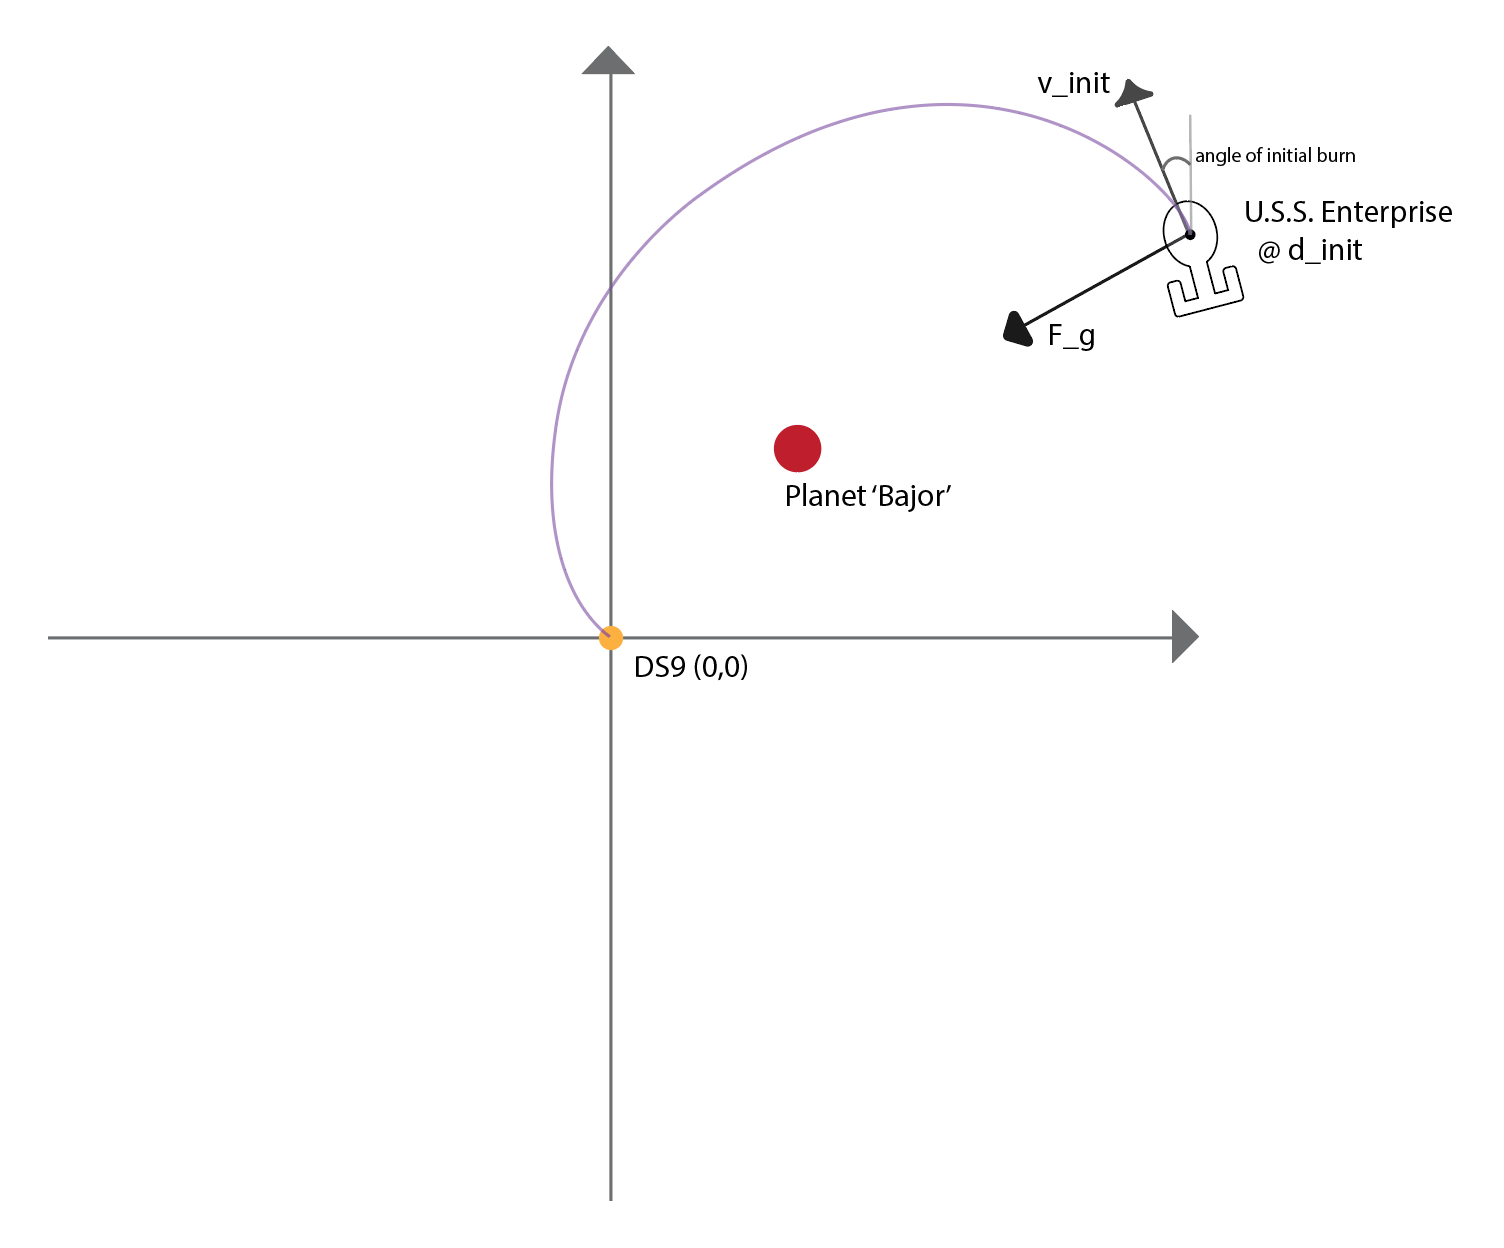

## Model


Our model is a fairly simple gravitational motion model with a system for including multiple static masses.
Some assumptions that we made:
 - The Enterprise and DS9 start at the same places relative to each other
 - Planet masses are static and don't affect each other gravitationally
 - The Enterprise and the planets are point masses
 - Once the Enterprise is roughly 6000 km away from DS9, it counts as being close enough to the station to get pulled in
 
Parameters are real numbers (the gravitational constant), researched from various Star Trek wikis, or made up based on reasonable planet stats. The way the model calculates the force vector on the Enterprise is it sums up all the individual force vectors into one net force that makes calculations easier. Our model only uses face validation (i.e. does it 'look' right), but it is theoretically internally valid as well.

To find the answer to our question, we sweep across a range of possible launch angles at the same launch velocity, then seeing which angles get close enough to DS9 to be pulled in.

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
from math import sin, cos, radians, sqrt

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton # = 1 kg * m / s**2

<Unit('newton')>

In [3]:
## STAR TREK UNIVERSE VALUES ##

bajor_coords = Vector(5e6,5e6) * m
planet3_coords = Vector(2e6, 4e6) * m
planet3_mass = 8.1e23 * kg
bajor_mass = 7.9344e24 * kg
ds9_orbit_rad = .1e7 *m
ent_mass = 3.205e9 * kg
ent_max_impulse_speed = 0.92 * 3e8 * m / s
moon_mass = 7.35e23 *kg
moon_dist = 4e6 *m
moon_coords = bajor_coords - Vector(moon_dist/2,(moon_dist/2)*sqrt(3))
#moon_coords = bajor_coords + Vector(-moon_dist,0*m)



array([3000000.        , 1535898.38486225]) <Unit('meter')>

In [4]:
## PARAMETERS ##

#masses for fictional bodies taken from online, where there is a vast wealth of star trek knowledge
#launch speed is maximum "impulse" speed, which wikipedia says is 1/4 lightspeed
#we assume enterprise starts 108,208,930 km from DS9 (the distance from venus to earth)

enterprise_mass = ent_mass
launch_speed = ent_max_impulse_speed / 6500 #close-ish at ~7000
planet_masses = [bajor_mass, moon_mass, planet3_mass] #array of planet masses
planet_coords = [bajor_coords, moon_coords, planet3_coords] #array of planet coordinates
num_planets = len(planet_masses)
G=6.67408e-11* ((m**3)*(kg**-1)*(s**-2))

params = Params(enterprise_mass = enterprise_mass,
                launch_speed = launch_speed,
                planet_masses = planet_masses,
                planet_coords = planet_coords,
                num_planets = num_planets,
                ds9_orbit_rad = ds9_orbit_rad,
                G = G)

,values
enterprise_mass,3205000000.0 kilogram
launch_speed,42461.53846153846 meter / second
planet_masses,"[7.9344e+24 kilogram, 7.35e+23 kilogram, 8.1e+..."
planet_coords,"[[5000000.0 meter, 5000000.0 meter], [3000000...."
num_planets,3
ds9_orbit_rad,1000000.0 meter
G,6.67408e-11 meter ** 3 / kilogram / second ** 2


In [5]:
def make_system(params, launch_angle):
    enterprise_mass = params.enterprise_mass
    launch_speed = params.launch_speed
    planet_masses = params.planet_masses
    planet_coords = params.planet_coords
    num_planets = params.num_planets
    ds9_orbit_rad = params.ds9_orbit_rad
    
    made_it = False
    
    v_x = launch_speed * -cos(radians(launch_angle-90)) # initial x velocity of enterprise
    v_y = launch_speed * -sin(radians(launch_angle-90)) #initial y velocity of enterprise
    
    d_x = 1.02e7 * m # initial x displacement of enterprise
    d_y = 1.02e7 * m # initial y displacement of enterprise
    """
    d_x = 7.652e1 * m # initial x displacement of enterprise
    d_y = 7.652e4 * m # initial y displacement of enterprise
    """
    init = State(d = Vector(d_x, d_y), v = Vector(v_x, v_y))
    
    t_end = 1200 * s
    dt = 3 *s
    
    return System(params, init=init, t_end=t_end, dt=dt)

In [6]:
def g_force(d, system):
    enterprise_mass = system.enterprise_mass
    planet_masses = system.planet_masses
    planet_coords = system.planet_coords
    num_planets = system.num_planets
    G = params.G
    
    f_g = Vector(0,0) * N #initializing summed gravitational forces as a zero vector with units of newtons

    for i in range(0, num_planets):
        mag = (G * planet_masses[i] * enterprise_mass) / (vector_dist(d, planet_coords[i]) ** 2) #magnitude of force vector
        direction = -(d - planet_coords[i]).hat()
        f_g += direction * mag
        #print(i, f_g)

    
    
    return f_g # net gravitational forces on enterprise from planets

In [7]:
def slope_func(state, t, system):
    d, v = state # enterprise's displacement vector and velocity vector
    enterprise_mass = system.enterprise_mass
    G = system.G
    
    dddt = v
    dvdt = g_force(d, system) / enterprise_mass
    #print(dvdt)
    
    return dddt, dvdt

In [8]:
def event_func(state, t, system):
    unpack(state)
    Ed, Ev = state
    if Ed.mag < system.ds9_orbit_rad:
        system.made_it = True
        return 0
    else:
        system.made_it = False
        return 1

## Results

We have a plot of all the swept trajectories, as well as individual plots of each individual winning trajectory. The winning trajectories for this specific configuration of planets are given as the titles of the individual trajectory plots (124.1379, 145.8620, and 148.9655 degrees “west” from “north”).


In [0]:
angle_array = linspace(90, 180, 30)
success_angles = []

plt.figure(figsize=(10, 10))
set_xlim((-0.25e7, 1.2e7))
set_ylim((-0.25e7, 1.2e7))
    

plot(0, 0, 'ko')
for planet in planet_coords:
    plot(planet.x, planet.y, 'ro')

for angle in angle_array:
    system = make_system(params, angle)
    results, details = run_ode_solver(system, slope_func)
    xs = results.d.extract('x')
    ys = results.d.extract('y')
    dist = [sqrt((x/m) ** 2 + (y/m) ** 2) for x,y in zip(xs, ys)]
    plot(xs, ys, 'b', linewidth = 0.5)
    if min(dist) < ds9_orbit_rad:
        success_angles.append((angle,results))

decorate(xlabel='x position',
         ylabel='y position')



In [0]:
def plot_trajectory(results, angle):
    plt.figure(figsize=(6, 6))
    #plt.legend(bbox_to_anchor=(1.02, 1.02))
    set_xlim((-0.25e7, 1.2e7))
    set_ylim((-0.25e7, 1.2e7))
    
    xs = results.d.extract('x')
    ys = results.d.extract('y')
    plot(xs, ys, 'b')
    plot(0, 0, 'ko')
    
    for planet in planet_coords:
        plot(planet.x, planet.y, 'ro')
    
    decorate(xlabel='Time (s)',
             ylabel='Position (m)',
             title='Launch Angle: ' + str(angle))

for winning_angle in success_angles:
    plot_trajectory(winning_angle[1],winning_angle[0])

In [0]:
def plot_position(results, angle):
    plt.figure(figsize=(6, 6))
    xs = results.d.extract('x')
    ys = results.d.extract('y')

    plot(xs)
    plot(ys)
    decorate(xlabel='Time (s)',
             ylabel='Position (m)',
             title='Launch Angle: ' + str(angle))
    
    
for winning_angle in success_angles:
    plot_position(winning_angle[1],winning_angle[0])

In [0]:
def plot_velocity(results, angle):
    plt.figure(figsize=(6, 6))
    xs = results.d.extract('x')
    ys = results.d.extract('y')
    plot(results.v)
        
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/s)',
             title='Launch Angle: ' + str(angle))

for winning_angle in success_angles:
    plot_velocity(winning_angle[1],winning_angle[0])

## Interpretation

We could run a similar situation for a non-fictional scenario. Problems of orbit, initial velocity, and net gravitational force vectors are ones we will continue to encounter in the real world space exploration programs. 
Our planets are static, which means that the situation isn't realistic at all. The planets in our simulation are unaffected by gravity or other forces at all, instead staying at their original points. If the planets moved around, the simulation would be much more accurate to a real-life situation.
Additionally, our model doesn't have any collision detection, so the Enterprise could theoretically pass right through Bajor's center of mass.
Our iteration process mostly consisted of testing individual elements until they worked, the applying them to "real-life" situations. 

